# Outline
1. Nonlinear classifiers
2. Kernel trick and kernel SVM
3. Ensemble Methods - Boosting
4. Classification Summary

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

In [2]:
def drawplane(w, b=None, c=None, wlabel=None, poscol=None, negcol=None, lw=2, ls='k-'):
    # w^Tx + b = 0
    # w0 x0 + w1 x1 + b = 0
    # x1 = -w0/w1 x0 - b / w1

    # OR
    # w^T (x-c) = 0 = w^Tx - w^Tc  --> b = -w^Tc
    if c != None:
        b = -sum(w*c)
    
    # the line
    if (abs(w[0])>abs(w[1])):   # vertical line
        x0 = array([-30,30])
        x1 = -w[0]/w[1] * x0 - b / w[1]
    else:                       # horizontal line
        x1 = array([-30,30])
        x0 = -w[1]/w[0] * x1 - b / w[0]
    
    # fill positive half-space or neg space
    if (poscol):
        polyx = [x0[0], x0[-1], x0[-1], x0[0]]
        polyy = [x1[0], x1[-1], x1[0], x1[0]]
        plt.fill(polyx, polyy, poscol, alpha=0.2)
    
    if (negcol):
        polyx = [x0[0], x0[-1], x0[0], x0[0]]
        polyy = [x1[0], x1[-1], x1[-1], x1[0]]
        plt.fill(polyx, polyy, negcol, alpha=0.2)
        
    # plot line
    lineplt, = plt.plot(x0, x1, ls, lw=lw)

    # the w
    if (wlabel):
        xp = array([0, -b/w[1]])
        xpw = xp+w
        plt.arrow(xp[0], xp[1], w[0], w[1], width=0.01)
        plt.text(xpw[0]-0.5, xpw[1], wlabel)
    return lineplt

def drawmargin(w,b,xmarg=None):
    wnorm = w / sqrt(sum(w**2))
    if xmarg == None:
        # calculate a point on the margin
        dm = 1 / sqrt(sum(w**2))
        xpt  = array([1,-w[0]/w[1]-b/w[1]])
        # then find the margin (assuming learned with SVM)
        xmarg = xpt + dm*wnorm
        xmarg2 = xpt - dm*wnorm
    else:
        # find the distance to the margin
        dm = (sum(w*xmarg)+b) / sqrt(sum(w**2))
        # move to the other side of the decision plane
        xmarg2 = xmarg - 2*dm*wnorm

    lin = drawplane(w, c=xmarg, ls='k--', lw=1)
    drawplane(w, c=xmarg2, ls='k--', lw=1)
    return lin

# Linear Classifiers
- So far we have only looked at _linear classifiers_
  - separate classes using a hyperplane (line, plane).
  - e.g., support vector machine, logistic regression

In [3]:
# generate random data
X,Y = datasets.samples_generator.make_blobs(n_samples=50, 
         centers=2, cluster_std=2, n_features=2, 
         center_box=[-5,5], random_state=4487)
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

lsdatafig = plt.figure()   
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap)
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
axbox = [-10,10,-10,10]
plt.axis(axbox); plt.grid(True);
plt.close()

# fit SVM (kernel is the type of decision surface...more in the next lecture)
clf = svm.SVC(kernel='linear', C=inf)
clf.fit(X, Y)
# get line parameters
w = clf.coef_[0]
b = clf.intercept_[0]

maxmfig = plt.figure()
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap)
l1 = drawplane(w, b, poscol='g', negcol='r')
l2 = drawmargin(w, b)
l3, = plt.plot(clf.support_vectors_[:,0], clf.support_vectors_[:,1],
         'ko',fillstyle='none', markeredgewidth=2)
plt.axis(axbox); plt.grid(True)
leg = plt.legend((l1,l2,l3), ('boundary', 'margin', 'support vectors'), 
           loc='lower right', fontsize=10)
leg.get_frame().set_facecolor('white') 
plt.close()

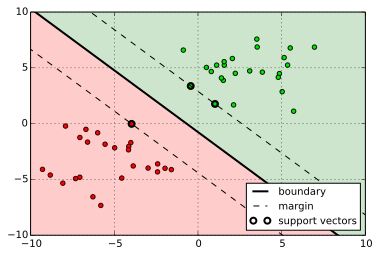

In [4]:
maxmfig

# Non-linear decision boundary
- What if the data is separable, but not linearly separable?

In [5]:
nlfig = plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
# type one - XOR
X1,Y1 = datasets.samples_generator.make_blobs(n_samples=100, 
         centers=array([[5,5],[-5,-5],[-5, 5], [5, -5]]), cluster_std=0.5, n_features=2, 
         random_state=4487)
Y1 = (Y1>=2)+0
plt.scatter(X1[:,0], X1[:,1], c=Y1, cmap=mycmap)
plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.grid(True)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

# type two - split
X2,Y2 = datasets.samples_generator.make_blobs(n_samples=100, 
         centers=array([[5],[-5],[0]]), cluster_std=0.5, n_features=1, 
         random_state=4487)
Y2 = (Y2>1)+0
plt.subplot(1,3,2)
plt.scatter(X2[:,0], zeros(X2.shape), c=Y2, cmap=mycmap)
plt.xlabel('$x$'); plt.grid(True)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])


# type three - moons
X3,Y3 = datasets.samples_generator.make_moons(n_samples=100,
                                             noise=0.1, random_state=4487)
plt.subplot(1,3,3)
plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap)
plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.grid(True)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.close()

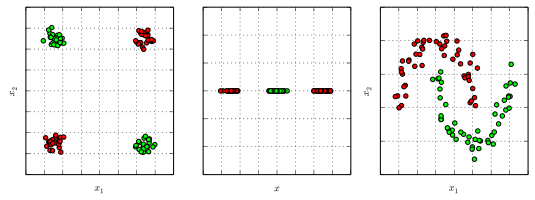

In [6]:
nlfig

# Idea - transform the input space
- map from input space $x \in \mathbb{R}^d$ to a new high-dimensional space $z \in \mathbb{R}^D$.
  - $z = \Phi(x)$, where $\Phi(x)$ is the transformation function.
- learn the linear classifier in the new space
  - if dimension of new space is large enough ($D>d$), then the data should be linearly separable

In [7]:
nl2fig = plt.figure(figsize=(9,7))

# type one - XOR
plt.subplot2grid((5,3),(0,0), rowspan=2)
plt.scatter(X1[:,0], X1[:,1], c=Y1, cmap=mycmap)
plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.grid(True)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

X1t = X1[:,0]*X1[:,1]

plt.subplot2grid((5,3),(2,0))
plt.annotate("", xy=(0, -1), xytext=(0,0.8), 
             arrowprops=dict(arrowstyle='Fancy,head_width=3,tail_width=2,head_length=2'))
plt.text(0.2,0,"$\Phi(x) = x_1*x_2$", fontsize=14)
plt.axis([-1, 1, -1, 1])
plt.axis('off')

plt.subplot2grid((5,3),(3,0), rowspan=2)
plt.scatter(X1t, zeros(X1t.shape), c=Y1, cmap=mycmap)
plt.xlabel('$x_1 x_2$'); plt.grid(True)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.plot([0,0],[-0.5,0.5], 'k-', lw=2)

# type two - split
plt.subplot2grid((5,3),(0,1), rowspan=2)
plt.scatter(X2[:,0], zeros(X2.shape), c=Y2, cmap=mycmap)
plt.xlabel('$x$'); plt.grid(True)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])


plt.subplot2grid((5,3),(2,1))
plt.annotate("", xy=(0, -1), xytext=(0,0.8), 
             arrowprops=dict(arrowstyle='Fancy,head_width=3,tail_width=2,head_length=2'))
plt.text(0.2,0,"$\Phi(x) = [x, x^2]$", fontsize=14)
plt.axis([-1, 1, -1, 1])
plt.axis('off')


X2t = c_[X2, X2**2]
plt.subplot2grid((5,3),(3,1), rowspan=2)
plt.scatter(X2t[:,0], X2t[:,1], c=Y2, cmap=mycmap)
plt.xlabel('$x$'); plt.ylabel('$x^2$');plt.grid(True)
plt.plot([-8,8],[10,10], 'k-', lw=2)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

# type three - moons
plt.subplot2grid((5,3),(0,2), rowspan=2)
plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap)
plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.grid(True)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

plt.subplot2grid((5,3),(2,2))
plt.annotate("", xy=(0, -1), xytext=(0,0.8), 
             arrowprops=dict(arrowstyle='Fancy,head_width=3,tail_width=2,head_length=2'))
plt.text(0.2,0,"$\Phi(x)$", fontsize=14)
plt.axis([-1, 1, -1, 1])
plt.axis('off')

plt.subplot2grid((5,3),(3,2), rowspan=2)
plt.arrow(0,0, 10,0, lw=2, head_width=1)
plt.arrow(0,0, 0,10, lw=2, head_width=1)
plt.arrow(0,0, -7,-7, lw=2, head_width=1)

X3t,Y3t = datasets.samples_generator.make_blobs(n_samples=100, 
          centers=array([[-5,5],[5,-5]]), cluster_std=2, n_features=2, 
          random_state=4487)
plt.scatter(X3t[:,0], X3t[:,1], c=Y3t, cmap=mycmap)
plt.fill([5, -5, -5, 5], [10, 2, -7, 1], alpha=0.5, color='gray', ls='solid')
plt.axis([-10, 12, -10, 12])
plt.text(-10,-12,"high-dimensional features space")
plt.axis('off')

plt.close()

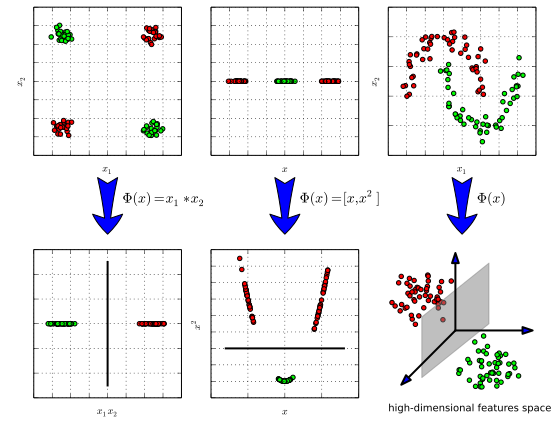

In [8]:
nl2fig

# SVM with transformed input
- Given a training set $\{x_i,y_i\}_{i=1}^N$, the original SVM training is:
  $$ \mathop{\mathrm{argmin}}_{w,b} \frac{1}{2} w^Tw\quad \mathrm{s.t.}~y_i(w^Tx_i+b)\geq 1,\quad 1\leq i \leq N$$
- Apply high-dimensional transform to input $x\rightarrow \Phi(x)$:
  $$ \mathop{\mathrm{argmin}}_{w,b} \frac{1}{2} w^Tw\quad \mathrm{s.t.}~y_i(w^T\Phi(x_i)+b)\geq 1,\quad 1\leq i \leq N$$

- **Note:** the hyperplane $w\in\mathbb{R}^D$ is now in the high-dimensional space!
  - if $D$ is very large,
    - calculating feature vector $\Phi(x_i)$ could be time consuming.
    - optimization could be very inefficient in high-dimensional space.

# SVM Dual Problem
- Using some convex optimization theory, the SVM problem can be rewritten as a _dual_ problem:
$$\mathop{\mathrm{argmax}}_{\alpha} \sum_i \alpha_i -\frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N \alpha_i\alpha_j y_i y_j \Phi(x_i)^T \Phi(x_j) \\ \mathrm{s.t.} \sum_{i=1}^N \alpha_iy_i = 0, \quad \alpha_i\geq 0$$
- Optimization variable $\alpha_i$ corresponds to each training sample $(x_i,y_i)$.
  - $\alpha_i=0$ when the sample point is not on the margin.
  - $\alpha_i>0$ when the sample point is on the margin (or violates).

- Recover the hyperplane $w$ as a sum of the margin points:
  - $w = \sum_{i=1}^N \alpha_i y_i \Phi(x_i)$
- Classify a new point $x_*$,  
  - $y_* = \mathrm{sign}(w^T\Phi(x_*)+b) = \mathrm{sign}(\sum_{i=1}^N \alpha_i y_i \Phi(x_i)^T \Phi(x_*) + b)$

# Kernel function
- the SVM dual problem is completely written in terms of _inner product_ between the high-dimensional feature vectors: $\Phi(x_i)^T \Phi(x_j)$
- So rather than explicitly calculate the high-dimensional vector $\Phi(x_i)$, 
  - we only need to calculate the inner product between two high-dim feature vectors.
- We call this a **kernel function**
  - $k(x_i, x_j) = \Phi(x_i)^T \Phi(x_j)$
  - calculating the kernel will be less expensive than explicitly calculating the high-dimensional feature vector and the inner product.

# Kernel trick
- Replacing the inner product with a kernel function in the optimziation problem is called the **kernel trick**.
  - _turns a linear classification algorithm into a non-linear classification algorithm_.
  - the shape of the decision boundary is determined by the kernel.

# Example: Polynomial kernel
- input vector $x=\left[\begin{matrix}x_1\\\vdots\\x_d\end{matrix}\right]\in\mathbb{R}^d$
- kernel between two vectors is a $p$-th order polynomial:
  - $k(x,x') = (x^Tx')^p = (\sum_{i=1}^d x_i x_i')^p$

- For example, $p=2$,
  $$k(x,x') = (x^T x')^2 = (\sum_{i=1}^d x_i x_i')^2 $$
  $$k(x,x')= \sum_{i=1}^d \sum_{j=1}^d (x_ix_i' x_jx_j')$$
  $$k(x,x')= \sum_{i=1}^d \sum_{j=1}^d (x_i x_j) (x_i' x_j') = \Phi(x)^T \Phi(x')$$
  - transformed feature space is the quadratic terms of the input vector: 
    $$ \Phi(x) = \left[\begin{matrix} x_1 x_1 \\ x_1 x_2 \\ \vdots  \\
    x_2 x_1 \\x_2 x_2 \\ \vdots \\
    x_d x_1 \\ \vdots \\ x_d x_d
    \end{matrix}\right]
    $$

# Example: Kernel SVM with polynomial kernel
- higher polynomial-order yields more complex decision boundaries.

In [9]:
inds = (Y3==0)
X4 = X3[inds]
Y4 = Y3[inds]
tmpX,tmpY = datasets.samples_generator.make_blobs(n_samples=20, 
         centers=1, cluster_std=0.2, n_features=2, 
         center_box=[0,0], random_state=4487)
X4 = vstack((X4,tmpX))
Y4 = r_[Y4, tmpY+1]

In [10]:
# fit SVM (poly kernel d=2)
clf = {}
clf[2] = svm.SVC(kernel='poly', degree=2, C=inf)
clf[2].fit(X4, Y4)

# fit SVM (poly kernel d=3)
clf[3] = svm.SVC(kernel='poly', degree=3, C=100)
clf[3].fit(X4, Y4)

# fit SVM (poly kernel d=4)
clf[4] = svm.SVC(kernel='poly', degree=4, C=100)
clf[4].fit(X4, Y4)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0, degree=4, gamma=0.0,
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [11]:
axbox = [-1.5, 1.5, -1.5, 1.5]
xr = [linspace(axbox[0], axbox[1], 50), 
      linspace(axbox[2], axbox[3], 50)]

# make a grid for calculating the posterior, 
#  then form into a big [N,2] matrix
xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

polysvmfig = plt.figure(figsize=(9,3))
i=1

for (x,clfx) in clf.iteritems():
    # calculate the posterior probability
    score = clfx.decision_function(allpts).reshape(xgrid0.shape)

    plt.subplot(1,3,i)
    i=i+1
    cmap = ([1,0,0], [1,0.7,0.7], [0.7,1,0.7], [0,1,0])
    CS = plt.contourf(xr[0], xr[1], score, colors=cmap, 
                      levels=[-1000, -1, 0, 1, 1000], alpha=0.3)
    #plt.clabel(CS, inline=1, fontsize=10)
    plt.contour(xr[0], xr[1], score, levels=[-1, 1], linestyles='dashed', color='k')
    plt.contour(xr[0], xr[1], score, levels=[0], linestyles='solid', color='k')

    l1, = plt.plot([-100,-100], [-100,-100], 'k-')
    l2, = plt.plot([-100,-100], [-100,-100], 'k--')

    plt.scatter(X4[:,0], X4[:,1], c=Y4, cmap=mycmap)
    l3, = plt.plot(clfx.support_vectors_[:,0], clfx.support_vectors_[:,1],
             'ko',fillstyle='none', markeredgewidth=2)
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.axis(axbox); plt.grid(True)
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    leg = plt.legend((l1,l2,l3), ('boundary', 'margin', 'support vectors'), 
               loc='lower right', fontsize=7)
    leg.get_frame().set_facecolor('white') 
    plt.title('polynomial p=' + str(x))
plt.close()

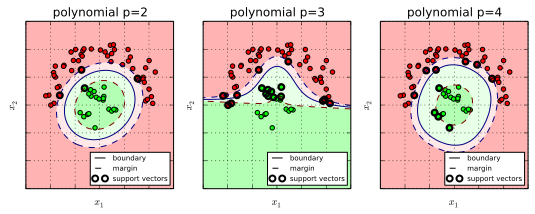

In [12]:
polysvmfig

# RBF kernel
- RBF kernel (radial basis function)
  - $k(x,x') = e^{-\gamma\|x-x'\|^2}$
  - similar to a Gaussian
- gamma $\gamma>0$ is the inverse bandwidth parameter of the kernel
  - controls the smoothness of the function
  - small $\gamma$ &#8594; wider Gaussian &#8594; smooth functions
  - large $\gamma$ &#8594; thin Gaussian &#8594; wiggly function

In [13]:
rbffig = plt.figure()
x = linspace(-10,10,500)
gammas = array([0.1, 1.0, 10.0])
ll = []
for g in gammas:
    kx = exp(-g*(x**2))
    lx, = plt.plot(x, kx)
    ll.append(lx)
plt.xlabel("$||x-x'||$")
plt.ylabel("$k(x,x')$")
plt.axis([-10, 10, 0, 1.1]); plt.grid(True)
plt.legend(ll, ("$\gamma=0.1$", "$\gamma=1$", "$\gamma=10$"))
plt.close()

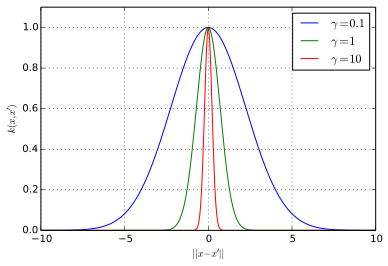

In [14]:
rbffig

# Kernel SVM with RBF kernel
- try different $\gamma$
  - each $\gamma$ yields different levels of smoothness of the decision boundary

In [15]:
# fit SVM (RBF)
gammas = [0.1, 1, 25]

clf = {}
for i in gammas:
    clf[i] = svm.SVC(kernel='rbf', gamma=i, C=1000)
    clf[i].fit(X3, Y3)

In [16]:
axbox = [-2, 3, -2, 2]
xr = [linspace(axbox[0], axbox[1], 50), 
      linspace(axbox[2], axbox[3], 50)]

# make a grid for calculating the posterior, 
#  then form into a big [N,2] matrix
xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

rbfsvmfig = plt.figure(figsize=(9,3))
i=1

for x in gammas:
    clfx = clf[x]
    # calculate the posterior probability
    score = clfx.decision_function(allpts).reshape(xgrid0.shape)

    plt.subplot(1,3,i)
    i=i+1
    cmap = ([1,0,0], [1,0.7,0.7], [0.7,1,0.7], [0,1,0])
    CS = plt.contourf(xr[0], xr[1], score, colors=cmap, 
                      levels=[-1000, -1, 0, 1, 1000], alpha=0.3)
    #plt.clabel(CS, inline=1, fontsize=10)
    plt.contour(xr[0], xr[1], score, levels=[-1, 1], linestyles='dashed', color='k')
    plt.contour(xr[0], xr[1], score, levels=[0], linestyles='solid', color='k')

    l1, = plt.plot([-100,-100], [-100,-100], 'k-')
    l2, = plt.plot([-100,-100], [-100,-100], 'k--')

    plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap)
    l3, = plt.plot(clfx.support_vectors_[:,0], clfx.support_vectors_[:,1],
             'ko',fillstyle='none', markeredgewidth=2)
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.axis(axbox); plt.grid(True)
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    leg = plt.legend((l1,l2,l3), ('boundary', 'margin', 'support vectors'), 
               loc='lower right', fontsize=7)
    leg.get_frame().set_facecolor('white') 
    plt.title('RBF $\gamma$=' + str(x))
plt.close()

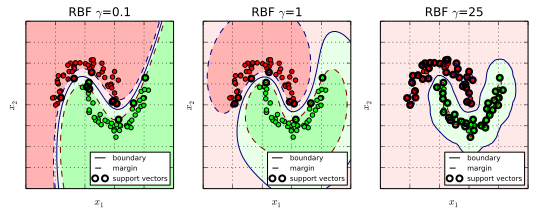

In [17]:
rbfsvmfig

# Example on Iris data
- Large $\gamma$ yields a complicated wiggly decision boundary.

In [18]:
# define class labels, plot markers, and feature labels
markers   = ('ro', 'gs'); lines = ('r-', 'g-')
featnames = ("petal length", "sepal width")
xr = [ linspace(2.5,7,50) , linspace(1.5, 4, 50) ]
axbox = [2.5, 7, 1.5, 4]

# load iris dataset from scikit-learn
iris = datasets.load_iris()    

# get the indices of the 2 classes of interest.
inds = squeeze( (iris.target==1) | (iris.target==2) )

# get the targets
target     = iris.target[inds]
classnums  = unique(target)
classnames = ('versicolor (1)', 'virginica (2)')
# make a colormap for viewing classes
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

# extract the data (each row is a sample)
# inds extracts rows, while
#  (2,1) extracts the two dimensions
# ix_ is a magic function to select a subarray
data = iris.data[ix_(inds, (2,1))]
print data.shape

(100, 2)


In [19]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  cross_validation.train_test_split(data, target, 
  train_size=0.5, test_size=0.5, random_state=4487)

print trainX.shape
print testX.shape

(50, 2)
(50, 2)


In [20]:
# fit SVM (RBF)
gammas = [0.1, 1, 10]

clf = {}
for i in gammas:
    clf[i] = svm.SVC(kernel='rbf', gamma=i, C=100)
    clf[i].fit(trainX, trainY)
    
# make a grid for calculating the posterior, 
#  then form into a big [N,2] matrix
xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

irbffig = plt.figure(figsize=(9,3))
i=1

for x in gammas:
    clfx = clf[x]
    # calculate the posterior probability
    score = clfx.decision_function(allpts).reshape(xgrid0.shape)

    plt.subplot(1,3,i)
    i=i+1
    cmap = ([1,0,0], [1,0.7,0.7], [0.7,1,0.7], [0,1,0])
    CS = plt.contourf(xr[0], xr[1], score, colors=cmap, 
                      levels=[-1000, -1, 0, 1, 1000], alpha=0.3)
    #plt.clabel(CS, inline=1, fontsize=10)
    plt.contour(xr[0], xr[1], score, levels=[-1, 1], linestyles='dashed', color='k')
    plt.contour(xr[0], xr[1], score, levels=[0], linestyles='solid', color='k')

    l1, = plt.plot([-100,-100], [-100,-100], 'k-')
    l2, = plt.plot([-100,-100], [-100,-100], 'k--')

    plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap)
    l3, = plt.plot(clfx.support_vectors_[:,0], clfx.support_vectors_[:,1],
             'ko',fillstyle='none', markeredgewidth=2)
    plt.xlabel(featnames[0]); plt.ylabel(featnames[1])
    plt.axis(axbox); plt.grid(True)
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    leg = plt.legend((l1,l2,l3), ('boundary', 'margin', 'support vectors'), 
               loc='lower right', fontsize=7)
    leg.get_frame().set_facecolor('white') 
    plt.title('RBF $\gamma$=' + str(x))
plt.close()

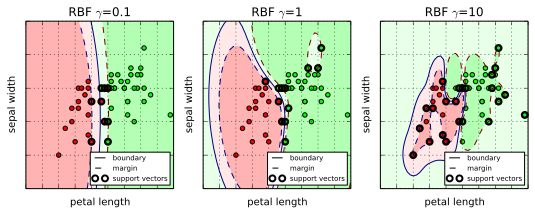

In [21]:
irbffig

# How to select the best kernel parameters?
- use cross-validation over possible kernel parameters and $C$ parameter
  - can be computationally expensive!

In [22]:
Cs     = logspace(-2,3,20)  # values of C
gammas = logspace(-4,3,20)  # values of gamma
print "Cs =", Cs
print "gammas =", gammas

avgscores = empty((len(Cs), len(gammas)))
                  
for i,C in enumerate(Cs):
    for j,gamma in enumerate(gammas):
        # create the SVM classifier
        clf = svm.SVC(kernel='rbf', C=C, gamma=gamma)

        # calculate the scores for this classifier
        myscore = cross_validation.cross_val_score(clf, trainX, trainY, cv=5)

        # record the average score
        avgscores[i,j] = mean(myscore)

# pick the best C
besti = argmax(avgscores)
(bestiC, bestig) = unravel_index(besti, avgscores.shape)
bestC = Cs[bestiC]
bestg = gammas[bestig]
print "bestC =", bestC, " (index " + str(bestiC) + ")"
print "bestg =", bestg, " (index " + str(bestig) + ")"
print bestiC
print bestig

Cs = [  1.00000000e-02   1.83298071e-02   3.35981829e-02   6.15848211e-02
   1.12883789e-01   2.06913808e-01   3.79269019e-01   6.95192796e-01
   1.27427499e+00   2.33572147e+00   4.28133240e+00   7.84759970e+00
   1.43844989e+01   2.63665090e+01   4.83293024e+01   8.85866790e+01
   1.62377674e+02   2.97635144e+02   5.45559478e+02   1.00000000e+03]
gammas = [  1.00000000e-04   2.33572147e-04   5.45559478e-04   1.27427499e-03
   2.97635144e-03   6.95192796e-03   1.62377674e-02   3.79269019e-02
   8.85866790e-02   2.06913808e-01   4.83293024e-01   1.12883789e+00
   2.63665090e+00   6.15848211e+00   1.43844989e+01   3.35981829e+01
   7.84759970e+01   1.83298071e+02   4.28133240e+02   1.00000000e+03]
bestC = 0.379269019073  (index 6)
bestg = 0.483293023857  (index 10)
6
10


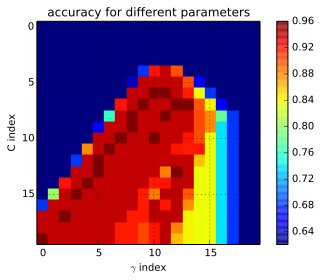

In [23]:
plt.figure()
plt.imshow(avgscores, interpolation='nearest')
plt.ylabel('C index')
plt.xlabel('$\gamma$ index')
plt.grid(True)
plt.title('accuracy for different parameters')
plt.colorbar()
plt.show()

In [24]:
# fit the SVM using all the data and the best C   
clf = svm.SVC(kernel='rbf', C=bestC, gamma=bestg)
clf.fit(trainX, trainY)

SVC(C=0.37926901907322497, cache_size=200, class_weight=None, coef0=0.0,
  degree=3, gamma=0.48329302385717521, kernel='rbf', max_iter=-1,
  probability=False, random_state=None, shrinking=True, tol=0.001,
  verbose=False)

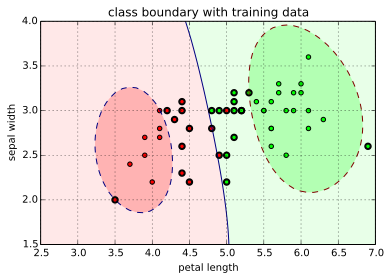

In [25]:
xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
allpts = c_[xgrid0.ravel(), xgrid1.ravel()]
score = clf.decision_function(allpts).reshape(xgrid0.shape)

cmap = ([1,0,0], [1,0.7,0.7], [0.7,1,0.7], [0,1,0])

plt.figure()
CS = plt.contourf(xr[0], xr[1], score, colors=cmap, 
                  levels=[-1000, -1, 0, 1, 1000], alpha=0.3)
plt.contour(xr[0], xr[1], score, levels=[-1, 1], linestyles='dashed', color='k')
plt.contour(xr[0], xr[1], score, levels=[0], linestyles='solid', color='k')

plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap)
l3, = plt.plot(clf.support_vectors_[:,0], clf.support_vectors_[:,1],
             'ko',fillstyle='none', markeredgewidth=1.5)
plt.axis([2.5, 7, 1.5, 4]); plt.grid(True);
plt.xlabel(featnames[0]); plt.ylabel(featnames[1])

plt.title('class boundary with training data');
plt.show()

In [26]:
# predict from the model
predY = clf.predict(testX)

# calculate accuracy
Ncorrect = sum(testY==predY)
acc      = mean(testY==predY)
print "number correct =", Ncorrect
print "test accuracy =", acc

number correct = 44
test accuracy = 0.88


# Kernel SVM Summary
- **Kernel Classifier:**
  - Kernel function defines the shape of the non-linear decision boundary.
    - implicitly transforms input feature into high-dimensional space.
    - uses linear classifier in high-dim space.
    - the decision boundary is non-linear in the original input space.
- **Training:**
  - Maximize the margin of the training data.
    - i.e., maximize the separation between the points and the decision boundary.
  - Use cross-validation to pick the hyperparameter $C$ and the kernel hyperparameters.

- **Advantages:**
  - non-linear decision boundary for more complex classification problems
  - some intuition from the type of kernel function used.
  - kernel function can also be used to do non-vector data.
- **Disadvantages:**
  - sensitive to the kernel function used.
  - sensitive to the $C$ and kernel hyperparameters.
  - computationally expensive to do cross-validation.

#  Kernels on other types of data
- **Histograms:** $x = [x_1,\cdots, x_d]$, $x_i$ is a bin value.
  - Bhattacharyya: $$k(x,x') = \sum_{i=1}^d \sqrt{x_i x'_i}$$
  - histogram intersection: $$k(x,x') = \sum_i \min(x_i, x_i')$$
  - $\chi^2$-RBF: $$k(x,x') = e^{-\gamma \chi^2(x,x')}$$
    - $\gamma$ is a inverse bandwidth parameter
    - $\chi^2$ distance: $\chi^2(x,x') = \sum_{i=1}^d\frac{(x_i-x'_i)^2}{\tfrac{1}{2}(x_i+x'_i)}$

- **Strings**: x = "...." (strings can be different sizes)
  $$k(x,x') = \sum_{s} w_s \phi_s(x)\phi_s(x')$$
  - $\phi_s(x)$ is the number of times substring $s$ appears in $x$.
  - $w_s>0$ is a weight.
- **Sets**: $X = \{x_1,\cdots, x_n\}$ (sets can be different sizes)
  - intersection kernel: $$k(X,X') = 2^{|X\cap X'|}$$
    - $|X\cap X'|$ = number of common elements.